In [13]:
import os

import numpy as np
import pandas as pd
from math import erfc, sqrt
from scipy import stats
import statsmodels.api as sm
import scipy.optimize as opt

from utils import rouwenhorst
from main import run

pd.set_option('display.max_columns', 500)

## 3.a Reproduce Mehra-Prescott

### Two-state Markov Chain

In [14]:
path_mehra = "./data/Shiller data extended.xlsx"
out, summ = run(n=2, path=path_mehra)

summ

/Users/chris/.pyenv/versions/3.9.4/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,mean,rho,std
regression,0.022761,-0.100142,0.039678
ar_moments,1.020689,-0.100142,0.039878
mc,1.020689,-0.100142,0.039878


### 10-state Markov Chain

In [15]:
out, summ = run(n=10, path=path_mehra)

summ

/Users/chris/.pyenv/versions/3.9.4/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,mean,rho,std
regression,0.022761,-0.100142,0.039678
ar_moments,1.020689,-0.100142,0.039878
mc,1.020689,-0.091026,0.039878


The 10-state chain appear to match the autocorrelation worse than the two-state, which is exact.

## 3.B NIPA Data long sample
### Two-state chain

In [16]:
path_nipa = "./data/PCE growth data.xlsx"
out, summ = run(n=2, path=path_nipa)

summ

/Users/chris/.pyenv/versions/3.9.4/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,mean,rho,std
regression,0.009307,0.4795,0.018700
ar_moments,1.017882,0.4795,0.021309
mc,1.017882,0.4795,0.021309


### 10-state chain

In [17]:
_, summ = run(n=10, path=path_nipa)

summ

/Users/chris/.pyenv/versions/3.9.4/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,mean,rho,std
regression,0.009307,0.479500,0.018700
ar_moments,1.017882,0.479500,0.021309
mc,1.017882,0.919996,0.021309


## 3.C NIPA data post-war
### Two-state chain

In [18]:
_, summ = run(n=2, path=path_nipa, start_year=1950)
summ

/Users/chris/.pyenv/versions/3.9.4/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,mean,rho,std
regression,0.008654,0.493172,0.013500
ar_moments,1.017075,0.493172,0.015519
mc,1.017075,0.493172,0.015519


### 10-state chain

In [19]:
_, summ = run(n=10, path=path_nipa, start_year=1950)
summ

/Users/chris/.pyenv/versions/3.9.4/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,mean,rho,std
regression,0.008654,0.493172,0.013500
ar_moments,1.017075,0.493172,0.015519
mc,1.017075,0.971377,0.015519


## 4.

Unconditional moments are matched in 3.B

In [20]:
# Calibrate chain from data
out, summ = run(n=2, path=path_nipa)
Z, P, pi, mu, sigma, rho = out['Z'], out['P'], out['stationary dist'], out['mean'], out['std'], out['rho']
gamma = 2
beta = np.exp(-0.02)

print("Conditional moments")
cond_mu = P @ Z
cond_std = np.sqrt((P @ Z**2) - cond_mu**2)


pd.DataFrame({'mu': cond_mu,
             'std': cond_std}, index=['Bad State', 'Good State'])

Conditional moments


/Users/chris/.pyenv/versions/3.9.4/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,mu,std
Bad State,1.007664,0.0187
Good State,1.028099,0.0187


In [21]:
def bond_return(beta, Z=Z, P=P, n=1, gamma=2):
    # Compute risk-free return from Markov Chain
    B_i = np.zeros(2)
    for i in range(2):
        for j in range(2):
            B_i[i] += beta * P[i, j] * Z[j]**(-gamma)
            
    Rf_i = 1/B_i - 1  # Net conditonal risk-free return
    
    B = pi @ Rf_i
    return B

# Solve for the beta that sets bond-return = 0.05 
beta = opt.fsolve(lambda beta: bond_return(beta) - 0.05, x0=np.exp(-0.02))[0]

beta

0.9858463267717398

In [22]:
def B2_cond_price(beta, Z=Z, P=P, n=1, gamma=2):
    b = np.zeros(n)
    
    for i in range(2):
        for j in range(2):
            for k in range(2):
                b[i] += P[i, j] * Z[j]**(-gamma) * P[j, k] * Z[k] **(-gamma)
    return b * beta**n
                
B2 = B2_cond_price(beta, n=2)
B2

array([0.9354742 , 0.88157146])

In [23]:
def B1_cond_price(beta, Z=Z, P=P, n=1, gamma=2):
    B1 = np.zeros(2)
    for i in range(2):
        for j in range(2):
            B1[i] += beta * P[i, j] * Z[j]**(-gamma)
    return B1

B1 = B1_cond_price(beta)
            
B1

array([0.9718843 , 0.93364498])

In [24]:
h1 = np.zeros(2)
for i in range(2):
    h1[i] = (B1 / B2[i] * P[i, :]).sum() - 1
    
print(f"Bond returns after 1 period: {h1}")
print(f'Bond prices after 1 period: {1/(1+h1)}')

pd.DataFrame({'B1': B1,
             "B2": B2,
             "Holding-return": h1}, index=['Bad State', 'Good State']).T

Bond returns after 1 period: [0.02828332 0.07035764]
Bond prices after 1 period: [0.97249462 0.93426716]


,Bad State,Good State
B1,0.971884,0.933645
B2,0.935474,0.881571
Holding-return,0.028283,0.070358


## Price-Dividend ratio in each state i


<div>
<img src=attachment:f3bc52b0-5d8a-4d13-8846-5e607e9847c0.png width="500"/>
</div>
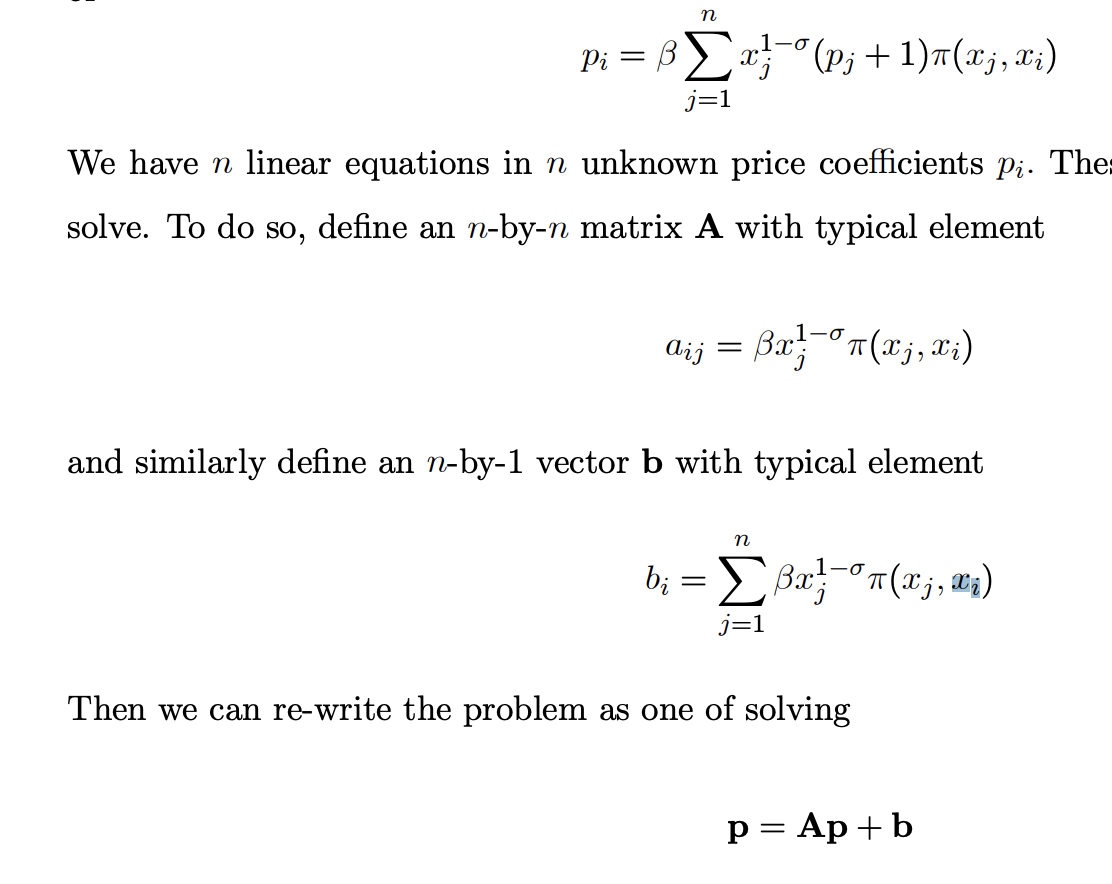

$$ \mathbf{p} = \begin{bmatrix} p_1 \\ p_2 \end{bmatrix}
    = \beta \begin{bmatrix} 
         \sum_{j=1}^n x_j^{1-\gamma} (p_j + 1) \Pi_{1,j}  \\  
         \sum_{j=1}^n x_j^{1-\gamma} (p_j + 1) \Pi_{2,j} 
         \end{bmatrix}  $$
    
$$ \mathbf{A} =
            \begin{bmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{bmatrix} =
            \beta \begin{bmatrix} 
            x_1^{1-\gamma} \Pi_{1,1}  & x_2^{1-\gamma} \Pi_{1,2} \\ 
            x_1^{1-\gamma} \Pi_{2,1} & x_2^{1-\gamma} \Pi_{2,2} 
            \end{bmatrix}$$
            
$$ \mathbf{b} = 
            \begin{bmatrix} b_{1} \\ b_{2} \end{bmatrix} =
            \beta \begin{bmatrix} 
            \sum_{j=1}^n x_j^{1-\gamma} \Pi_{1,j} \\
            \sum_{j=1}^nx_j^{1-\gamma} \Pi_{2,j}
            \end{bmatrix} =
            \begin{bmatrix}
              a_{11} + a_{12} \\ a_{21} + a_{22}
            \end{bmatrix}
            $$

So $\mathbf{p} = \mathbf{Ap} + \mathbf{b}$ becomes

$$ 
\beta \begin{bmatrix} 
 \sum_{j=1}^n x_j^{1-\gamma} (p_j + 1) \Pi_{1,j}  \\  
 \sum_{j=1}^n x_j^{1-\gamma} (p_j + 1) \Pi_{2,j} 
 \end{bmatrix}
 =
\beta \begin{bmatrix} 
x_1^{1-\gamma} \Pi_{1,1}  & x_2^{1-\gamma} \Pi_{1,2} \\ 
x_1^{1-\gamma} \Pi_{2,1} & x_2^{1-\gamma} \Pi_{2,2} 
\end{bmatrix}
\beta \begin{bmatrix} 
 \sum_{j=1}^n x_j^{1-\gamma} (p_j + 1) \Pi_{1,j}  \\  
 \sum_{j=1}^n x_j^{1-\gamma} (p_j + 1) \Pi_{2,j} 
 \end{bmatrix}
+
\beta \begin{bmatrix} 
\sum_{j=1}^n x_j^{1-\gamma} \Pi_{1,j} \\
\sum_{j=1}^nx_j^{1-\gamma} \Pi_{2,j}
\end{bmatrix}
$$

In [25]:
def equity_price():
    A = beta * Z**(1-gamma) * P
    b = A.sum(axis=1)

    I = np.identity(2)
    S = np.linalg.inv(I - A) @ b
    return S

S = equity_price()
S

array([32.18727579, 31.00294884])

In [26]:
P_D = S / Z
P_D

array([32.29797004, 29.83374248])

## Return on equity

In [27]:
def return_equity():
    re = np.zeros((2, 2))
    for i in range(2):
        for j in range(2):
            re[j, i] = Z[j]*(S[j]+1)/S[i]-1
    return re

re = return_equity()
re

array([[0.02753442, 0.0667867 ],
       [0.0332396 , 0.07270983]])

In [28]:
# Excess returns
rf = 1/B1 - 1  # 1-period risk-free rate

excess_ret = (re.T - rf).T
excess_ret

array([[-0.00139465,  0.03785764],
       [-0.03783134,  0.00163889]])

## Unconditional moments of equity and bond returns

In [29]:
def uncond_re(re):
    cond_re = (P * re.T).sum(axis=1)
    return pi @ cond_re

re_uncond = uncond_re(re)

uncond_rf = pi @ rf

re_uncond

0.05009376398854534

In [30]:
cond_re = (P * re.T).sum(axis=1)
cond_ER = cond_re - rf

ER_mean = uncond_re(re) - pi @ rf
std = np.sqrt( (pi @ cond_ER**2) - ER_mean**2)
rho1 = np.diag(P)

display(pd.DataFrame([ER_mean, std, rho1], index=['Mean', 'Std', 'Rho']).T)
print("_"*40)

,Mean,Std,Rho
0,0.000094,0.000004,"[0.7397501537169732, 0.7397501537169732]"


________________________________________


In [31]:
cond_re

array([0.02901919, 0.07116834])

In [32]:
Z

array([0.99657272, 1.03919074])